## Importing Libraries and Data

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Reading the data
data = pd.read_excel('online_retail_II.xlsx', sheet_name=1, index_col=False)

## Data Check and Cleaning

In [3]:
# Checking for % of null values
round(100*(data.isnull().sum() / len(data)), 2)

Invoice         0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    24.93
Country         0.00
dtype: float64

In [4]:
# Considering data where customer ID is not null
data = data[~data['Customer ID'].isnull()]

In [5]:
# Checking for null values again
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [6]:
# Checkinng for duplicates
rows_after_drop_dup = len(data.drop_duplicates())
rows = len(data)
print(f"Rows before dropping duplicates = {rows}\n\
Rows after dropping duplicates = {rows_after_drop_dup}\n\
Number of duplicate values = {rows - rows_after_drop_dup}")

Rows before dropping duplicates = 406830
Rows after dropping duplicates = 401605
Number of duplicate values = 5225


In [7]:
# Dropping Duplicates
data.drop_duplicates(inplace=True)

## RFM Analysis

### Calculating the Recency

In [8]:
# Calulating the Recency
recency = data.groupby('Customer ID', as_index=False)['InvoiceDate'].max() #grouping by the Customer ID and getting the max invoice date
recency.columns = ['Customer ID', 'Last Purchase Date'] # renaming the columns
recent_date = recency['Last Purchase Date'].max() # getting the latest date of purchase
recency['Recency'] = recency['Last Purchase Date'].apply(lambda x: (recent_date - x).days) # calculating the recency of purchase in number of days

In [9]:
recency.head()

,Customer ID,Last Purchase Date,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12347.0,2011-12-07 15:52:00,1
2,12348.0,2011-09-25 13:13:00,74
3,12349.0,2011-11-21 09:51:00,18
4,12350.0,2011-02-02 16:01:00,309


### Calculating the Frequency

In [10]:
frequency = data.groupby('Customer ID', as_index=False)['InvoiceDate'].count() # calculating the frequency of customers purchases
frequency.columns = ['Customer ID', 'Frequency']
frequency.head()

,Customer ID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


### Calculating the Monetary Value

In [11]:
data['Total'] = data['Quantity'] * data['Price'] # Calculating the total price = quantity * price
monetary = data.groupby('Customer ID', as_index = False)['Total'].sum() # Agg data by sum of total price with respect to customer ID 
monetary.columns = ['Customer ID', 'Monetary'] # renaming columns

In [12]:
monetary.head()

,Customer ID,Monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


### Caculating the RFM Rank and Score

In [13]:
rf = recency.merge(frequency, on='Customer ID') # grouping recency and frequency data frames
rfm = rf.merge(monetary, on='Customer ID') #grouping recency, frequency and monetary data frames
rfm.head()

,Customer ID,Last Purchase Date,Recency,Frequency,Monetary
0,12346.0,2011-01-18 10:17:00,325,2,0.00
1,12347.0,2011-12-07 15:52:00,1,182,4310.00
2,12348.0,2011-09-25 13:13:00,74,31,1797.24
3,12349.0,2011-11-21 09:51:00,18,73,1757.55
4,12350.0,2011-02-02 16:01:00,309,17,334.40


In [14]:
rfm['R Rank'] = rfm.Recency.rank(ascending=False) # calculating the rank of Recency
rfm['F Rank'] = rfm.Frequency.rank(ascending=False) # calculating the rank of Frequency
rfm['M Rank'] = rfm.Monetary.rank(ascending=False) # calculating the rank of Monetary

rfm['R_rank_norm'] = (rfm['R Rank'] / rfm['R Rank'].max())*100 # calculating the normalized rank of Recency
rfm['F_rank_norm'] = (rfm['F Rank'] / rfm['F Rank'].max())*100 # calculating the normalized rank of Frequency
rfm['M_rank_norm'] = (rfm['M Rank'] / rfm['M Rank'].max())*100 # calculating the normalized rank of Monetary

rfm.drop(['R Rank', 'F Rank', 'M Rank'], axis=1, inplace=True) # dropping rank columns

rfm.head()

,Customer ID,Last Purchase Date,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,12346.0,2011-01-18 10:17:00,325,2,0.00,3.865741,98.407570,98.959286
1,12347.0,2011-12-07 15:52:00,1,182,4310.00,97.719907,12.000923,7.296432
2,12348.0,2011-09-25 13:13:00,74,31,1797.24,38.182870,58.469882,22.301006
3,12349.0,2011-11-21 09:51:00,18,73,1757.55,72.974537,33.602585,22.895700
4,12350.0,2011-02-02 16:01:00,309,17,334.40,5.578704,75.905839,70.082342


In [15]:
# Calculating RFM Score using Formula

rfm['RFM_Score'] = 0.15*rfm['R_rank_norm'] + 0.28*\
rfm['F_rank_norm'] + 0.57*rfm['M_rank_norm']
rfm['RFM_Score'] *= 0.05
rfm = rfm.round(2)
rfm.head(10)

,Customer ID,Last Purchase Date,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
0,12346.0,2011-01-18 10:17:00,325,2,0.00,3.87,98.41,98.96,4.23
1,12347.0,2011-12-07 15:52:00,1,182,4310.00,97.72,12.00,7.30,1.11
2,12348.0,2011-09-25 13:13:00,74,31,1797.24,38.18,58.47,22.30,1.74
3,12349.0,2011-11-21 09:51:00,18,73,1757.55,72.97,33.60,22.90,1.67
4,12350.0,2011-02-02 16:01:00,309,17,334.40,5.58,75.91,70.08,3.10
5,12352.0,2011-11-03 14:37:00,35,95,1545.41,57.85,26.75,25.77,1.54
6,12353.0,2011-05-19 17:47:00,203,4,89.00,17.01,95.87,96.04,4.21
7,12354.0,2011-04-21 13:11:00,231,58,1079.40,14.16,40.21,34.84,1.66
8,12355.0,2011-05-09 13:49:00,213,13,459.40,15.80,81.62,60.27,2.98
9,12356.0,2011-11-17 08:40:00,22,59,2811.43,68.84,39.74,13.17,1.45


In [16]:
# Segmentating customers based on their scores 
rfm['Customer_Segment'] = np.where(rfm['RFM_Score'] > 4.5, 'Top Customers',\
                                  np.where(rfm['RFM_Score'] > 4, 'High Value Customers',\
                                          np.where(rfm['RFM_Score'] > 3, 'Medium Value Customers',\
                                                  np.where(rfm['RFM_Score'] > 1.6, 'Low Value Customers', 'Lost Customers'))))
rfm[['Customer ID', 'RFM_Score', 'Customer_Segment']].head(20)

,Customer ID,RFM_Score,Customer_Segment
0,12346.0,4.23,High Value Customers
1,12347.0,1.11,Lost Customers
2,12348.0,1.74,Low Value Customers
3,12349.0,1.67,Low Value Customers
4,12350.0,3.10,Medium Value Customers
5,12352.0,1.54,Lost Customers
6,12353.0,4.21,High Value Customers
7,12354.0,1.66,Low Value Customers
8,12355.0,2.98,Low Value Customers
9,12356.0,1.45,Lost Customers


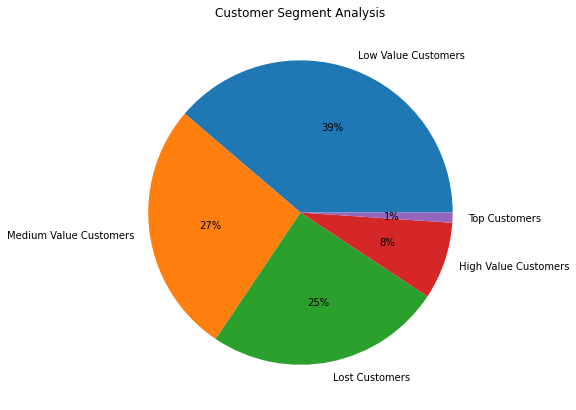

In [17]:
plt.figure(figsize=(10,7))
plt.pie(rfm['Customer_Segment'].value_counts(), labels = rfm['Customer_Segment'].value_counts().index,\
        autopct = '%0.f%%')
plt.title('Customer Segment Analysis')
plt.show()

## Making Clusters from Data

### Preparing the data

In [22]:
dummy_df = pd.get_dummies(data['Country'], drop_first=True)
combined_data = pd.concat([data, dummy_df], 1)
combined_data.drop('Country', 1, inplace=True)

C:\Users\Shubham\AppData\Local\Temp\ipykernel_23396\1663788104.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  combined_data = pd.concat([data, dummy_df], 1)
C:\Users\Shubham\AppData\Local\Temp\ipykernel_23396\1663788104.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  combined_data.drop('Country', 1, inplace=True)


In [28]:
grouped_data = combined_data.groupby('Customer ID', as_index=False).sum()
merged_data = rfm.merge(grouped_data, on='Customer ID')

In [33]:
filtered_data = merged_data[['Recency', 'Frequency', 'Monetary',\
       'R_rank_norm', 'F_rank_norm', 'M_rank_norm', 'RFM_Score',\
                            'Quantity', 'Price', 'Total', 'Austria', 'Bahrain',\
       'Belgium', 'Brazil', 'Canada', 'Channel Islands', 'Cyprus',\
       'Czech Republic', 'Denmark', 'EIRE', 'European Community', 'Finland',\
       'France', 'Germany', 'Greece', 'Iceland', 'Israel', 'Italy', 'Japan',\
       'Lebanon', 'Lithuania', 'Malta', 'Netherlands', 'Norway', 'Poland',\
       'Portugal', 'RSA', 'Saudi Arabia', 'Singapore', 'Spain', 'Sweden',\
       'Switzerland', 'USA', 'United Arab Emirates', 'United Kingdom',\
       'Unspecified']]

In [34]:
scalar = StandardScaler()

scaled_data = scalar.fit_transform(filtered_data)

In [37]:
scaled_data

array([[ 2.32202285, -0.39205703, -0.23042003, ..., -0.02124653,
        -0.38308827, -0.02470078],
       [-0.89373323,  0.3932925 ,  0.29405406, ..., -0.02124653,
        -0.39271436, -0.02470078],
       [-0.1691956 , -0.2655285 , -0.01171799, ..., -0.02124653,
        -0.39271436, -0.02470078],
       ...,
       [-0.83418219, -0.34406345, -0.20892998, ..., -0.02124653,
        -0.3301448 , -0.02470078],
       [-0.87388289,  2.74497804,  0.01849586, ..., -0.02124653,
         3.07748959, -0.02470078],
       [-0.48680114, -0.09536943, -0.00684561, ..., -0.02124653,
        -0.05580135, -0.02470078]])

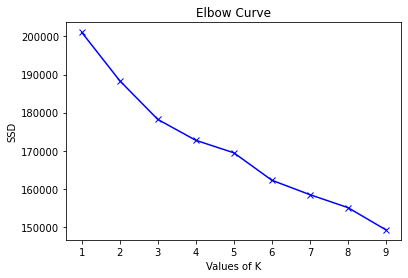

In [39]:
# Plotting the elbow curve
k_vals = range(1,10)
ssd = []

for i in k_vals:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_data)
    ssd.append(kmeans.inertia_)
    
plt.plot(k_vals, ssd, 'bx-')
plt.title('Elbow Curve')
plt.xlabel('Values of K')
plt.ylabel('SSD')
plt.show()

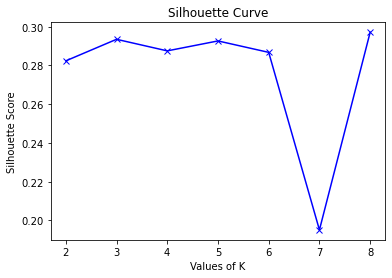

In [41]:
# Calculating the silhouette score
sil_score = []
k_val = [2, 3, 4, 5, 6, 7, 8]
for i in k_val:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_data)
    cluster_labels = kmeans.labels_
    sil_score.append(silhouette_score(scaled_data, cluster_labels))
plt.plot(k_val, sil_score, 'bx-')
plt.title('Silhouette Curve')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.show()

- Choosing the number of clusters as 5 based on Silhouette score and elbow curve

In [75]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

In [76]:
test = rfm.copy()
test['Cluster'] = clusters

In [77]:
test.head()

,Customer ID,Last Purchase Date,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_Segment,Cluster
0,12346.0,2011-01-18 10:17:00,325,2,0.00,3.87,98.41,98.96,4.23,High Value Customers,1
1,12347.0,2011-12-07 15:52:00,1,182,4310.00,97.72,12.00,7.30,1.11,Lost Customers,3
2,12348.0,2011-09-25 13:13:00,74,31,1797.24,38.18,58.47,22.30,1.74,Low Value Customers,3
3,12349.0,2011-11-21 09:51:00,18,73,1757.55,72.97,33.60,22.90,1.67,Low Value Customers,3
4,12350.0,2011-02-02 16:01:00,309,17,334.40,5.58,75.91,70.08,3.10,Medium Value Customers,1


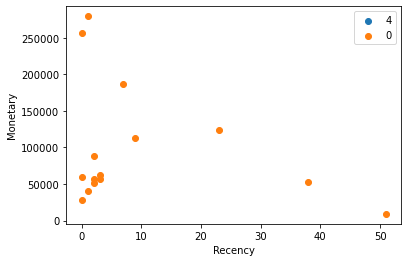

In [78]:
plt.scatter(test[test['Cluster'] == 4]['Recency'], test[test['Cluster'] == 4]['Monetary'], cmap='red', label='4')
plt.scatter(test[test['Cluster'] == 0]['Recency'], test[test['Cluster'] == 0]['Monetary'], cmap='blue', label='0')
plt.legend()
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

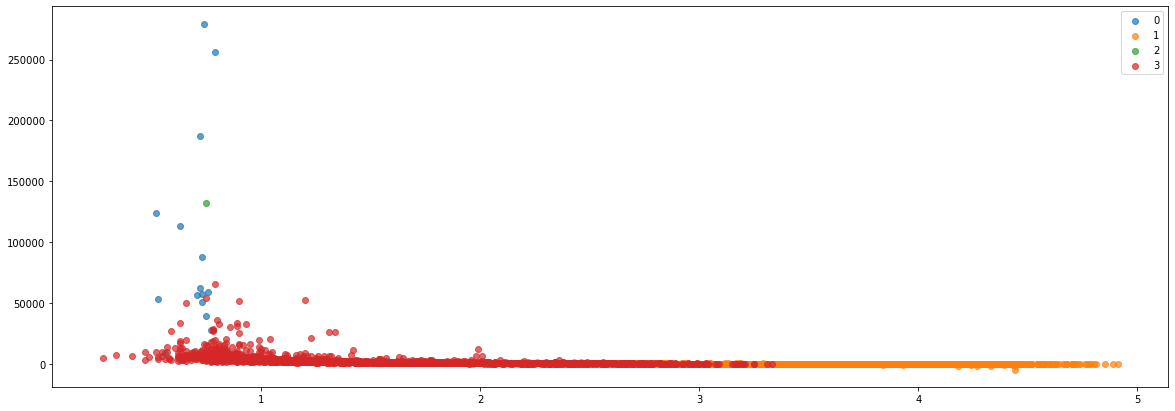

In [80]:
clusters = sorted(test['Cluster'].unique().tolist())
plt.figure(figsize=(20,7))
for i in clusters:
    plt.scatter(test[test['Cluster']==i]['RFM_Score'], test[test['Cluster']==i]['Monetary'], label = i, alpha=0.7)
plt.legend()
plt.show()